In [65]:
import os
import json
import pandas as pd
from openai import OpenAI  # Thay đổi import
from tqdm import tqdm
import time
from dotenv import load_dotenv
import logging
from typing import List, Dict, Any, Optional
from concurrent.futures import ThreadPoolExecutor
import threading
import matplotlib.pyplot as plt
import numpy as np

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv('../.env')

# Configure OpenAI client
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

def test_openai_connection():
    """Test OpenAI API connection"""
    if not os.getenv('OPENAI_API_KEY'):
        logger.error("OPENAI_API_KEY not found!")
        logger.info("Please add OPENAI_API_KEY to your .env file")
        return False
        
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": "Hello"}],
            max_tokens=5
        )
        logger.info("OpenAI API connection successful!")
        return True
    except Exception as e:
        logger.error(f"API connection failed: {e}")
        return False

def evaluate_answer_with_gpt(query: str, pred_answer: str, gt_answer: str, max_retries: int = 3) -> Optional[int]:
    """Evaluate answer using GPT-4o Mini"""
    prompt = f"""You are a judge who evaluates the quality of answers to questions. You should provide a score in the scale of 1 to 10 (without explanation), where 1 is the predicted answer is completely irrelevant to the ground truth answer or the question, and 10 is the predicted answer is exactly the same as the ground truth answer in the semantic meaning.
The question is: {query}. The predicted answer is: {pred_answer}. The ground truth answer is: {gt_answer}.
"""
    
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are an evaluation judge. Respond only with a number from 1 to 10."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=10,
                temperature=0
            )
            
            score_text = response.choices[0].message.content.strip()
            score = int(score_text)
            
            if 1 <= score <= 10:
                return score
            else:
                logger.warning(f"Invalid score: {score_text}")
                return None
                
        except Exception as e:
            logger.warning(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            
    logger.error(f"Failed to evaluate after {max_retries} attempts")
    return None

def extract_data_from_json(file_path: str) -> pd.DataFrame:
    """Extract data from JSON file"""
    logger.info(f"Loading data from {file_path}")
    
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    records = []
    for dataset_key, dataset in data.items():
        if not isinstance(dataset, dict):
            continue
        
        results = dataset.get("individual_results", {})
        for test_type, test_result in results.items():
            for item in test_result.get("detailed_results", []):
                # Process ground_truth - convert to string to avoid type conversion
                ground_truth = item.get("ground_truth", [])
                if isinstance(ground_truth, list) and len(ground_truth) > 0:
                    gt_text = str(ground_truth[0])  # Chuyển về string
                else:
                    gt_text = str(ground_truth) if ground_truth else ""

                records.append({
                    "dataset": dataset_key,
                    "test_type": test_type,
                    "question": str(item.get("question", "")),
                    "predicted_answer": str(item.get("predicted_answer", "")),
                    "ground_truth": gt_text,
                    "question_id": str(item.get("question_id", ""))
                })

    # FIX: Thêm return statement này
    df = pd.DataFrame(records)
    logger.info(f"Extracted {len(df)} records from {len(data)} datasets")
    return df

def evaluate_dataframe_batched(df: pd.DataFrame, max_workers: int = 5, batch_size: int = 50) -> pd.DataFrame:
    """Evaluate with batching and parallel processing"""
    
    if not test_openai_connection():
        logger.error("Cannot proceed without API connection")
        return df
    
    # Add evaluation columns
    df['gpt_score'] = None
    df['evaluation_status'] = 'pending'
    df['evaluation_timestamp'] = None
    
    total_records = len(df)
    logger.info(f"Starting batched evaluation: {total_records} records, {max_workers} workers, batch size {batch_size}")
    
    # Process in batches
    for start_idx in range(0, total_records, batch_size):
        end_idx = min(start_idx + batch_size, total_records)
        batch_df = df.iloc[start_idx:end_idx].copy()
        
        logger.info(f"Processing batch {start_idx//batch_size + 1}: rows {start_idx}-{end_idx}")
        
        # Parallel processing for this batch
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            def evaluate_batch_row(index_row):
                index, row = index_row
                try:
                    score = evaluate_answer_with_gpt(
                        query=row['question'],
                        pred_answer=row['predicted_answer'],
                        gt_answer=row['ground_truth']
                    )
                    return index, score, 'success' if score is not None else 'failed'
                except Exception as e:
                    logger.error(f"Error evaluating row {index}: {e}")
                    return index, None, 'error'
            
            # Execute batch
            results = list(tqdm(
                executor.map(evaluate_batch_row, batch_df.iterrows()),
                total=len(batch_df),
                desc=f"Batch {start_idx//batch_size + 1}"
            ))
            
            # Update main DataFrame
            for index, score, status in results:
                df.at[index, 'gpt_score'] = score
                df.at[index, 'evaluation_status'] = status
                df.at[index, 'evaluation_timestamp'] = pd.Timestamp.now()
        
        # Save progress after each batch
        df.to_csv("evaluation_progress.csv", index=False, encoding="utf-8-sig")
        logger.info(f"Completed batch {start_idx//batch_size + 1}/{(total_records-1)//batch_size + 1}")
    
    logger.info("All batches completed!")
    return df

def analyze_results(df: pd.DataFrame) -> Dict[str, Any]:
    """Analyze evaluation results"""
    # Filter successful evaluations
    successful_df = df[df['evaluation_status'] == 'success'].copy()
    
    if len(successful_df) == 0:
        logger.warning("No successful evaluations found")
        return {}
    
    # Overall statistics
    overall_stats = {
        'total_questions': len(df),
        'successful_evaluations': len(successful_df),
        'failed_evaluations': len(df) - len(successful_df),
        'success_rate': len(successful_df) / len(df) * 100,
        'mean_score': successful_df['gpt_score'].mean(),
        'median_score': successful_df['gpt_score'].median(),
        'std_score': successful_df['gpt_score'].std(),
        'min_score': successful_df['gpt_score'].min(),
        'max_score': successful_df['gpt_score'].max()
    }
    
    # By dataset
    dataset_stats = successful_df.groupby('dataset')['gpt_score'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    # By test type
    test_type_stats = successful_df.groupby('test_type')['gpt_score'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    # Score distribution
    score_distribution = successful_df['gpt_score'].value_counts().sort_index()
    
    results = {
        'overall': overall_stats,
        'by_dataset': dataset_stats,
        'by_test_type': test_type_stats,
        'score_distribution': score_distribution
    }
    
    return results

def save_results(df: pd.DataFrame, analysis: Dict[str, Any], base_filename: str = "gpt_evaluation_results"):
    """Save results to CSV format"""
    
    # Save main results
    csv_path = f"../notebooks/{base_filename}.csv"
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    logger.info(f"Results saved to {csv_path}")
    
    # Save statistics as separate CSV
    if 'overall' in analysis:
        stats_df = pd.DataFrame([analysis['overall']]).T
        stats_df.columns = ['Value']
        stats_path = f"../notebooks/{base_filename}_stats.csv"
        stats_df.to_csv(stats_path, encoding="utf-8-sig")
        logger.info(f"Statistics saved to {stats_path}")
    
    logger.info("Results saved successfully!")

def main():
    """Main execution function"""
    
    # File paths
    json_file = "../outputs/main_evaluation/all_datasets_summary.json"
    
    # Check if file exists
    if not os.path.exists(json_file):
        logger.error(f"File not found: {json_file}")
        return
    
    # Check for API key
    if not os.getenv('OPENAI_API_KEY'):
        logger.error("OPENAI_API_KEY not found in environment variables")
        logger.info("Please set your OpenAI API key in a .env file or environment variable")
        return
    
    try:
        # Step 1: Extract data
        logger.info("=== STEP 1: DATA EXTRACTION ===")
        df = extract_data_from_json(json_file)
        print(f"Extracted {len(df)} records")
        
        # Step 2: Evaluate with GPT-4o Mini (Parallel)
        logger.info("=== STEP 2: GPT EVALUATION (PARALLEL + BATCHED) ===")
        df_evaluated = evaluate_dataframe_batched(df.copy(), max_workers=3, batch_size=50) # 3 workers đồng thời
        
        # Step 3: Analyze results
        logger.info("=== STEP 3: ANALYSIS ===")
        analysis = analyze_results(df_evaluated)
        
        # Print summary
        if 'overall' in analysis:
            stats = analysis['overall']
            logger.info(f"""
=== EVALUATION SUMMARY ===
Total Questions: {stats['total_questions']}
Successful Evaluations: {stats['successful_evaluations']}
Success Rate: {stats['success_rate']:.1f}%
Average Score: {stats['mean_score']:.2f}
Score Range: {stats['min_score']} - {stats['max_score']}
Standard Deviation: {stats['std_score']:.2f}
            """)
        
        # Step 4: Save results
        logger.info("=== STEP 4: SAVING RESULTS ===")
        save_results(df_evaluated, analysis)
        
        logger.info("All tasks completed successfully!")
        return df_evaluated
        
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        return None

# Execute main function
if __name__ == "__main__":
    # Run the evaluation
    result_df = main()

2025-06-28 01:39:04,656 - INFO - === STEP 1: DATA EXTRACTION ===
2025-06-28 01:39:04,656 - INFO - Loading data from ../outputs/main_evaluation/all_datasets_summary.json
2025-06-28 01:39:04,761 - INFO - Extracted 464 records from 3 datasets
2025-06-28 01:39:04,763 - INFO - === STEP 2: GPT EVALUATION (PARALLEL + BATCHED) ===


Extracted 464 records


2025-06-28 01:39:05,413 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-28 01:39:05,416 - INFO - ✅ OpenAI API connection successful!
2025-06-28 01:39:05,418 - INFO - Starting batched evaluation: 464 records, 3 workers, batch size 50
2025-06-28 01:39:05,419 - INFO - Processing batch 1: rows 0-50
Batch 1:   2%|▏         | 1/50 [00:00<00:21,  2.25it/s]2025-06-28 01:39:06,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-28 01:39:06,551 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Batch 1:  10%|█         | 5/50 [00:01<00:10,  4.26it/s]2025-06-28 01:39:07,158 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-28 01:39:07,360 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-28 01:39:07,544 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completion

In [66]:
result_df

,dataset,test_type,question,predicted_answer,ground_truth,question_id,gpt_score,evaluation_status,evaluation_timestamp
0,AM,closed_end,What is the prerequisite for Marxist-Leninist ...,There are no prerequisites for this course.,none,question_1.json,3,success,2025-06-28 01:39:17.010159
1,AM,closed_end,Is it true that Marxist-Leninist Philosophy a ...,"Yes, the Marxist-Leninist Philosophy (ID: BAA0...",Yes,question_2.json,10,success,2025-06-28 01:39:17.010159
2,AM,closed_end,Is it true that Marxist-Leninist Philosoph cou...,Yes,yes,question_3.json,10,success,2025-06-28 01:39:17.010159
3,AM,closed_end,What is the prerequisite for the Marxist-Lenin...,None.,none,question_4.json,10,success,2025-06-28 01:39:17.010159
4,AM,closed_end,How many chapters does the Marxist-Leninist Po...,Six,6,question_5.json,10,success,2025-06-28 01:39:17.010159
...,...,...,...,...,...,...,...,...,...
459,MCS,multihop2,Name the Compulsory courses offered in the odd...,"Marxist-Leninist Philosophy, Analysis 1A, and ...",The Compulsory courses offered in the odd seme...,question_26.json,3,success,2025-06-28 01:40:39.905109
460,MCS,multihop2,Which Elective courses available in the even s...,None.,The Elective course available in the even seme...,question_27.json,1,success,2025-06-28 01:40:39.906098
461,MCS,multihop2,What are the Compulsory courses offered in the...,Analysis of Data Structures and Algorithms cou...,The Compulsory course offered in the even seme...,question_28.json,9,success,2025-06-28 01:40:39.906098
462,MCS,multihop2,"From the courses Analysis 1A, Measure Theory a...",Mathematical Statistics (ID: MTH10404),The Compulsory course offered in the even seme...,question_29.json,10,success,2025-06-28 01:40:39.906098


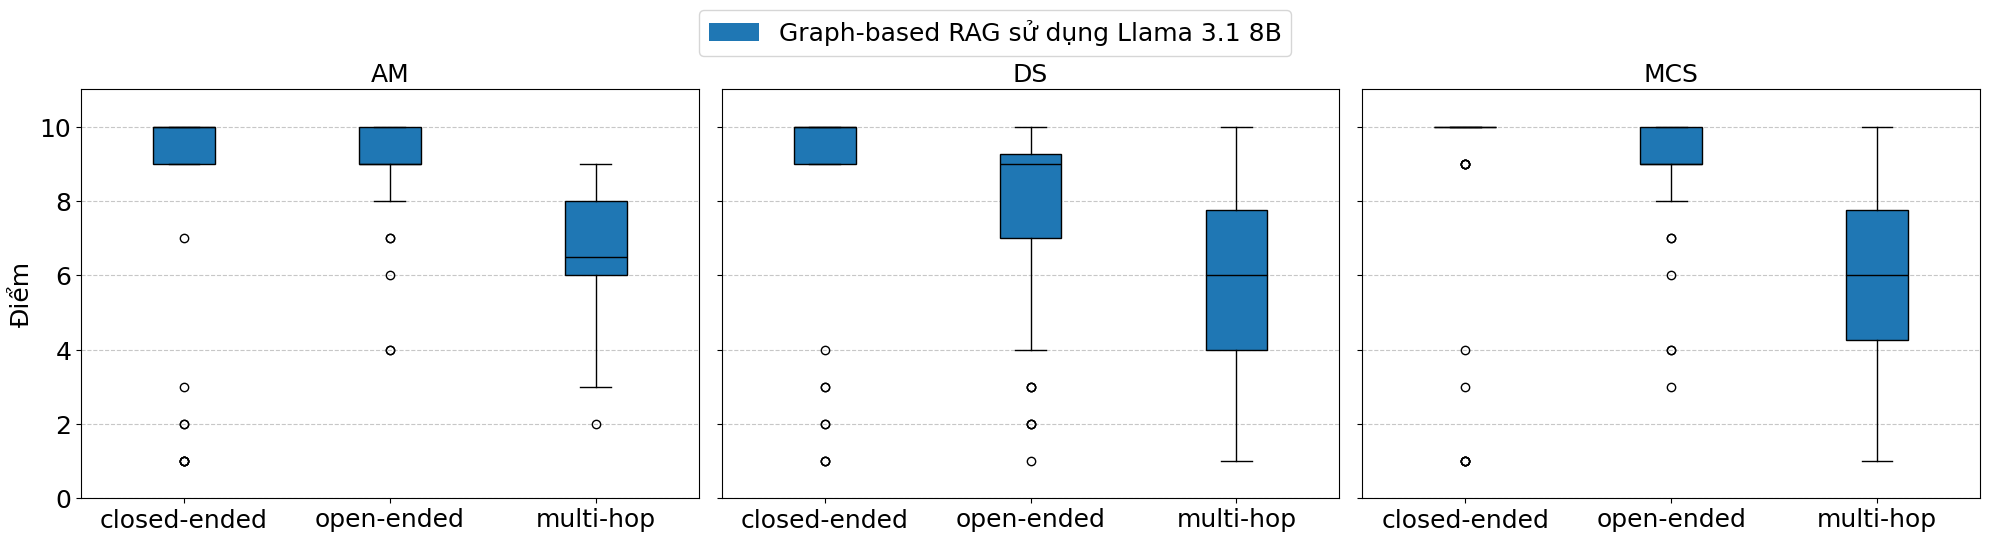

In [78]:
# Setup
fontsize = 18
majors = ["AM", "DS", "MCS"]

# Prepare data for DataFrame for each major (following original structure)
dfs = []
for major in majors:
    major_data = result_df[result_df['dataset'] == major].copy()
    
    # Only keep successful evaluations with valid scores
    major_data = major_data[
        (major_data['evaluation_status'] == 'success') & 
        (major_data['gpt_score'].notna())
    ]
    
    records = []
    # Create records in the same format as original
    for _, row in major_data.iterrows():
        records.append({
            'method': 'Graph-based RAG sử dụng Llama 3.1 8B',  # Single method name
            'QA Type': row['test_type'], 
            'Score': row['gpt_score']
        })
    
    dfs.append(pd.DataFrame(records))

# Plot grouped boxplot as subplots (3 columns, 1 row)
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
colors = plt.get_cmap('tab10').colors
width = 0.3

for idx, (ax, df, major) in enumerate(zip(axes, dfs, majors)):
    methods = df['method'].unique()
    for i, method in enumerate(methods):
        pos = [1 + i*width, 2 + i*width, 3 + i*width]
        data = [
            df[(df['method'] == method) & (df['QA Type'] == 'closed_end')]['Score'],
            df[(df['method'] == method) & (df['QA Type'] == 'opened_end')]['Score'],
            df[(df['method'] == method) & (df['QA Type'] == 'multihop2')]['Score']
        ]
        bp = ax.boxplot(
            data,
            positions=pos,
            widths=width,
            patch_artist=True,
            boxprops=dict(facecolor=colors[i % len(colors)]),
            medianprops=dict(color='black')
        )
    ax.set_xticks([1 + width*(len(methods)-1)/2, 2 + width*(len(methods)-1)/2, 3 + width*(len(methods)-1)/2])
    ax.set_xticklabels(['closed-ended', 'open-ended', 'multi-hop'], fontsize=fontsize)
    ax.set_title(major, fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, 11)  # Set appropriate y-limit for GPT scores
    if idx == 0:
        ax.set_ylabel('Điểm', fontsize=fontsize)

# Create a shared legend outside the subplots
handles = [plt.Rectangle((0,0),1,1,facecolor=colors[i % len(methods)]) for i in range(len(methods))]
fig.legend(
    handles,
    methods,
    ncols=len(methods),
    fontsize=fontsize,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.1),
)
plt.tight_layout()
plt.savefig("../results/gpt4_judgement_boxplot_llama31_8b.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [68]:
dfs

[    dataset   test_type                                           question  \
 0        AM  closed_end  What is the prerequisite for Marxist-Leninist ...   
 1        AM  closed_end  Is it true that Marxist-Leninist Philosophy a ...   
 2        AM  closed_end  Is it true that Marxist-Leninist Philosoph cou...   
 3        AM  closed_end  What is the prerequisite for the Marxist-Lenin...   
 4        AM  closed_end  How many chapters does the Marxist-Leninist Po...   
 ..      ...         ...                                                ...   
 159      AM   multihop2  Can you specify the course type, semester offe...   
 160      AM   multihop2  What are the course type, semester offered, an...   
 161      AM   multihop2  What are the course type, semester offered, an...   
 162      AM   multihop2  What are the course type, semester offered, an...   
 163      AM   multihop2  Who are the instructors for General Economics,...   
 
                                       predicted_a